# Implementation of Logistic Regression  and Random Forest

In [1]:
import pandas as pd
import numpy as np
from collections import OrderedDict

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

from sklearn import metrics 
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score
from sklearn.preprocessing import MinMaxScaler

Loading training data obtained after feature creation process for user based features, product based features and user-product based feature. Refer 2.Instacart-feature_engineering and flatfile creation process.ipynb 

In [2]:
#training data
df_X=pd.read_csv("flatfile_5june_complete.csv")

The test data just contains orderid and products corresponding to the current order. 

But in order to predict whether a product will be present in the current order or not, many user based features, product based features and user-product based features are required. This will be obtained following steps mentioned in **testdata_flatfile.ipynb.**


In [3]:
#final testing data
df_Test=pd.read_csv("flatfile_testdata.csv")

### Segregating Training data (flatfile) to testing  data, validation data and training data

In [3]:
np.random.seed(100)

#obtain list of unique user ids . They are training user ids
total_users = df_X['user_id'].unique() 

#obtain list of test user ids by randomly choosing 20% of userids from total_users
test_users = np.random.choice(total_users, size=int(total_users.shape[0] * .20), replace=False)


#obtaining training data,validation data and test data.
df_X_tr, df_X_te = df_X[~df_X['user_id'].isin(test_users)], df_X[df_X['user_id'].isin(test_users)]
                        
val_index = np.random.choice(df_X_tr.index, int(len(df_X_tr.index)/4), replace=False)
df_X_val = df_X.loc[val_index]
df_X_tr = df_X.loc[~df_X.index.isin(val_index)]                        

#obtaining true labels
y_tr, y_val, y_te = df_X_tr['in_cart'], df_X_val['in_cart'], df_X_te['in_cart']
X_tr, X_val, X_te = df_X_tr.drop(['product_id','user_id','latest_cart','in_cart'],axis=1), \
             df_X_val.drop(['product_id','user_id','latest_cart','in_cart'],axis=1), \
             df_X_te.drop(['product_id','user_id','latest_cart','in_cart'],axis=1), \
        
scaler = MinMaxScaler()
X_tr = pd.DataFrame(scaler.fit_transform(X_tr), columns=X_tr.columns)
X_val = pd.DataFrame(scaler.fit_transform(X_val), columns=X_val.columns)
X_te = pd.DataFrame(scaler.fit_transform(X_te), columns=X_te.columns)
    


## Logistic Regression

In [8]:
# Create Logistic Regression classifier object
lr = LogisticRegression(class_weight='balanced')

#Train Logistic Regression classifier
log_sm_reg=lr.fit(X_tr, y_tr)

#Predicting for test data called X_te (this is obtained by splitting 20% of train data)
y_pred_LR = log_sm_reg.predict(X_te)
scores_LR = metrics.accuracy_score(y_te, y_pred_LR)
scores_LR

0.852246300278243

overall Accuracy of model is 85.22%

### Model Performance
#### Precision ,Recall,f1-score for  Logistic Regrssion
0: Product is absent in latest cart(not a reorder) 

1: Product is present in latest cart (reorder)

In [9]:
from sklearn.metrics import classification_report
print(classification_report(y_te,y_pred_LR))

             precision    recall  f1-score   support

          0       0.94      0.90      0.92   1065128
          1       0.34      0.47      0.39    121245

avg / total       0.88      0.85      0.86   1186373



- Of all the instances when the classifier classified a product as not being in the user's cart, 94% of times it was correct. **Precision for Class 0**:= 94%
- For all instances that where the product was not part of user's latest order, 90% of time it was correctly classified.**Recall for Class 0**: 90%
- **F1 Score for Class 0**: 0.92
- In this testing dataset there were 1065128 instances of the product not being reordered.

-----------------------------------------------------------------------------------------------
- Of all the instances when the classifier classified a product as being in the user's cart, 34% of times it was correct. **Precision for Class 1**:= 34%
- For all instances that where the product was a part of user's latest order, 47% of time it was correctly classified.**Recall for Class 1**: 47%
- **F1 Score for Class 1**: 0.39
- In this testing dataset there were 121245 instances of the same product being reordered.

-----------------------------------------------------------------------------------------------

The training and testing data has class imbalance.


#### Confusion Matrix: Predicted vs true labels

In [6]:
pd.crosstab(y_te,y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,954025,111103,1065128
1,64188,57057,121245
All,1018213,168160,1186373



**Out of 1065128 instances of a product not being ordered** -
- 954025 times the classifier was correctly able to predict that the product would not be reordered
- 111103   times the classifier misclassified a not ordered product as reordered product.

**Out of 121245 instances of a product being reordered** -
- 64188 times the classifier misclassified a reordered product as not currently ordered.
- 57057 times the classifier correctly classified product as reordered

-----------------------------------------------------------------------------------------------

#### ROC Curve

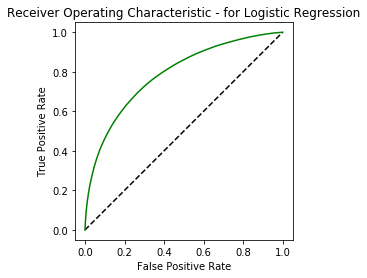

0.7868745505797903


In [12]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
y_score_LR = log_sm_reg.predict_proba(X_te)[:,1]

fpr_LR, tpr_LR,_ = roc_curve(y_te, y_score_LR)
roc_auc_LR = auc(fpr_LR, tpr_LR)

# Plotting our Baseline..
plt.plot([0,1],[0,1], linestyle='--', color = 'black')
plt.plot(fpr_LR, tpr_LR, color = 'green')
plt.title('Receiver Operating Characteristic - for Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()
print (roc_auc_LR)

### Testing of Logistic Regression on Test dataset
The final test data from order_products__test_cap.csv (order-product pair) is used for evaluating the performance of logistic regression 

In [7]:
#obtaining true labels of test data
y_te_1= df_Test['in_cart']

In [8]:
X_te_1 =df_Test.drop(['product_id','user_id','latest_cart','in_cart'],axis=1)
X_te_1 = pd.DataFrame(scaler.fit_transform(X_te_1), columns=X_te_1.columns)

In [9]:
#Predicting labels for test data
y_pred_test = log_sm_reg.predict(X_te_1)
scores = metrics.accuracy_score(y_te_1, y_pred_test)
scores

0.7678985455096302

Accuracy on test data is 76.7%

#### Confusion Matrix: Predicted vs true labels for TEST data

In [10]:
pd.crosstab(y_te_1,y_pred_test, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,1396049,390199,1786248
1,70991,129780,200771
All,1467040,519979,1987019


In the testing data Out of 1987019 instances of products and its corresponding orders, Only 200771 of those products were also previously ordered by those users

**Out of 1786248 instances of a product not being ordered ** -
- 1396049 times the classifier was correctly able to predict that the product would not be reordered
- 390199 times the classifier misclassified a not ordered product as reordered product.

**Out of 200771 instances of a product being reordered** -
- 70991 times the classifier misclassified a reordered product as not currently ordered.
- 129780 times the classifier correctly classified product as reordered


In [11]:
from sklearn.metrics import classification_report
print(classification_report(y_te_1,y_pred_test))

             precision    recall  f1-score   support

          0       0.95      0.78      0.86   1786248
          1       0.25      0.65      0.36    200771

avg / total       0.88      0.77      0.81   1987019



On the test dataset:
- **Class 0** : Precision = 95% | Recall =78% | F1 Score=0.86
- **Class 1** : Precision = 25% | Recall =65% | F1 Score=0.36